In [1]:
import numpy as np
from jax.config import config
config.update("jax_enable_x64", True)
config.update('jax_platform_name', 'gpu')
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit, vmap, lax
from ehrlich_aberth_jax import ehrlich_aberth
from astropy.convolution import Tophat2DKernel

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
%config InlineBackend.figure_format='retina'

import VBBinaryLensing
VBBL = VBBinaryLensing.VBBinaryLensing()
VBBL.RelTol = 1e-08

from functools import partial

gpu_ops: <module 'ehrlich_aberth_jax.gpu_ops' from '/home/fb90/miniforge3/envs/caustics/lib/python3.9/site-packages/ehrlich_aberth_jax/gpu_ops.cpython-39-x86_64-linux-gnu.so'>


In [2]:
@jit
def compute_polynomial_coeffs(w, a, e1, N=2):    
    wbar = jnp.conjugate(w)
    
    p_0 = -a**2 + wbar**2
    p_1 = a**2*w - 2*a*e1 + a - w*wbar**2 + wbar
    p_2 = 2*a**4 - 2*a**2*wbar**2 + 4*a*wbar*e1 - 2*a*wbar - 2*w*wbar
    p_3 = -2*a**4*w + 4*a**3*e1 - 2*a**3 + 2*a**2*w*wbar**2 - 4*a*w*wbar*e1 +\
        2*a*w*wbar + 2*a*e1 - a - w
    p_4 = -a**6 + a**4*wbar**2 - 4*a**3*wbar*e1 + 2*a**3*wbar + 2*a**2*w*wbar +\
        4*a**2*e1**2 - 4*a**2*e1 + 2*a**2 - 4*a*w*e1 + 2*a*w
    p_5 = a**6*w - 2*a**5*e1 + a**5 - a**4*w*wbar**2 - a**4*wbar + 4*a**3*w*wbar*e1 -\
        2*a**3*w*wbar + 2*a**3*e1 - a**3 - 4*a**2*w*e1**2 + 4*a**2*w*e1 - a**2*w

    p = jnp.array([p_0, p_1, p_2, p_3, p_4, p_5])
        
    return p

@jit
def lens_eq(z, w, e, r):
    return vmap(lambda z: -w + z - jnp.sum(e/(jnp.conjugate(z) - jnp.conjugate(r))))(z)

@jit
def lens_eq_jac_det(z, e, r):
    return vmap(
        lambda z: 1. - jnp.abs(jnp.sum(e/(jnp.conjugate(z) - jnp.conjugate(r))**2))**2
    )(z)

@jit
def compute_magnification_map(wgrid, a, e1):
    ncoeffs = 6
    ny, nx = wgrid.shape
    
    # Compute complex polynomial coefficients for each source position
    coeffs = vmap(vmap(lambda w: compute_polynomial_coeffs(w, a, e1)))(wgrid)
    
    # Compute roots
    roots = ehrlich_aberth(coeffs.reshape(-1, ncoeffs)).reshape(ny*nx, ncoeffs - 1)

    # Evaluate lens equation for all roots
    e = jnp.array([e1, 1. - e1])
    r = jnp.array([a, -a])
    fn = lambda z, w: lens_eq(z, w, e, r)
    lens_eq_eval = vmap(fn, in_axes=(0, 0))(roots.reshape(-1, 5), wgrid.reshape(-1))

    # Mask out roots which don't satisfy the lens equation
    mask_valid = jnp.abs(lens_eq_eval) < 1e-10

    # Evaluate the magnification
    det = vmap(lambda z: lens_eq_jac_det(z, e, r), in_axes=0)(roots)
    mag = (1./jnp.abs(det))*mask_valid
    
    return mag.sum(axis=-1).reshape((ny, nx))


# Comparison to VBB - point source

In [3]:
# Define 2D grid in the source plane
npts = 50
width = 2.

# Lens postion
a = 0.5*0.9

# Lens mass ratio
e1 = 0.8
e2 = 1. - e1
q = e1/e2
x_cm = (e1 - e2)*a

x = jnp.linspace(-0.5*width, 0.5*width, npts)
y = jnp.linspace(-0.5*width, 0.5*width, npts)
xgrid, ygrid = jnp.meshgrid(x,y)
wgrid = xgrid + 1j*ygrid

mag = compute_magnification_map(wgrid , a, e1)

In [4]:
mag_vbb = np.zeros(wgrid.shape)

for i in range(wgrid.shape[0]):
    for j in range(wgrid.shape[1]):
        mag_vbb[i, j] = VBBL.BinaryMag0(
            2*a, q, jnp.real(wgrid[i, j]) - x_cm, jnp.imag(wgrid[i, j]),
        )

Text(0.5, 1.0, 'diff')

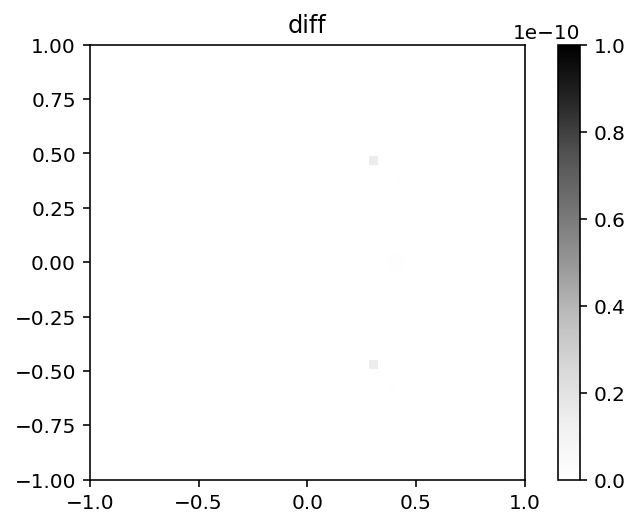

In [5]:
fig, ax = plt.subplots(figsize=(6,4))
im = ax.pcolormesh(
    jnp.real(wgrid), jnp.imag(wgrid), mag - mag_vbb, cmap='Greys', norm=colors.Normalize(vmin=0, vmax=1e-10)
)

ax.set(xlim=(-0.5*width, 0.5*width), ylim=(-0.5*width, 0.5*width))
ax.set_aspect(1)
plt.colorbar(im)
ax.set_title('diff')

# Brute-force integration in the source plane

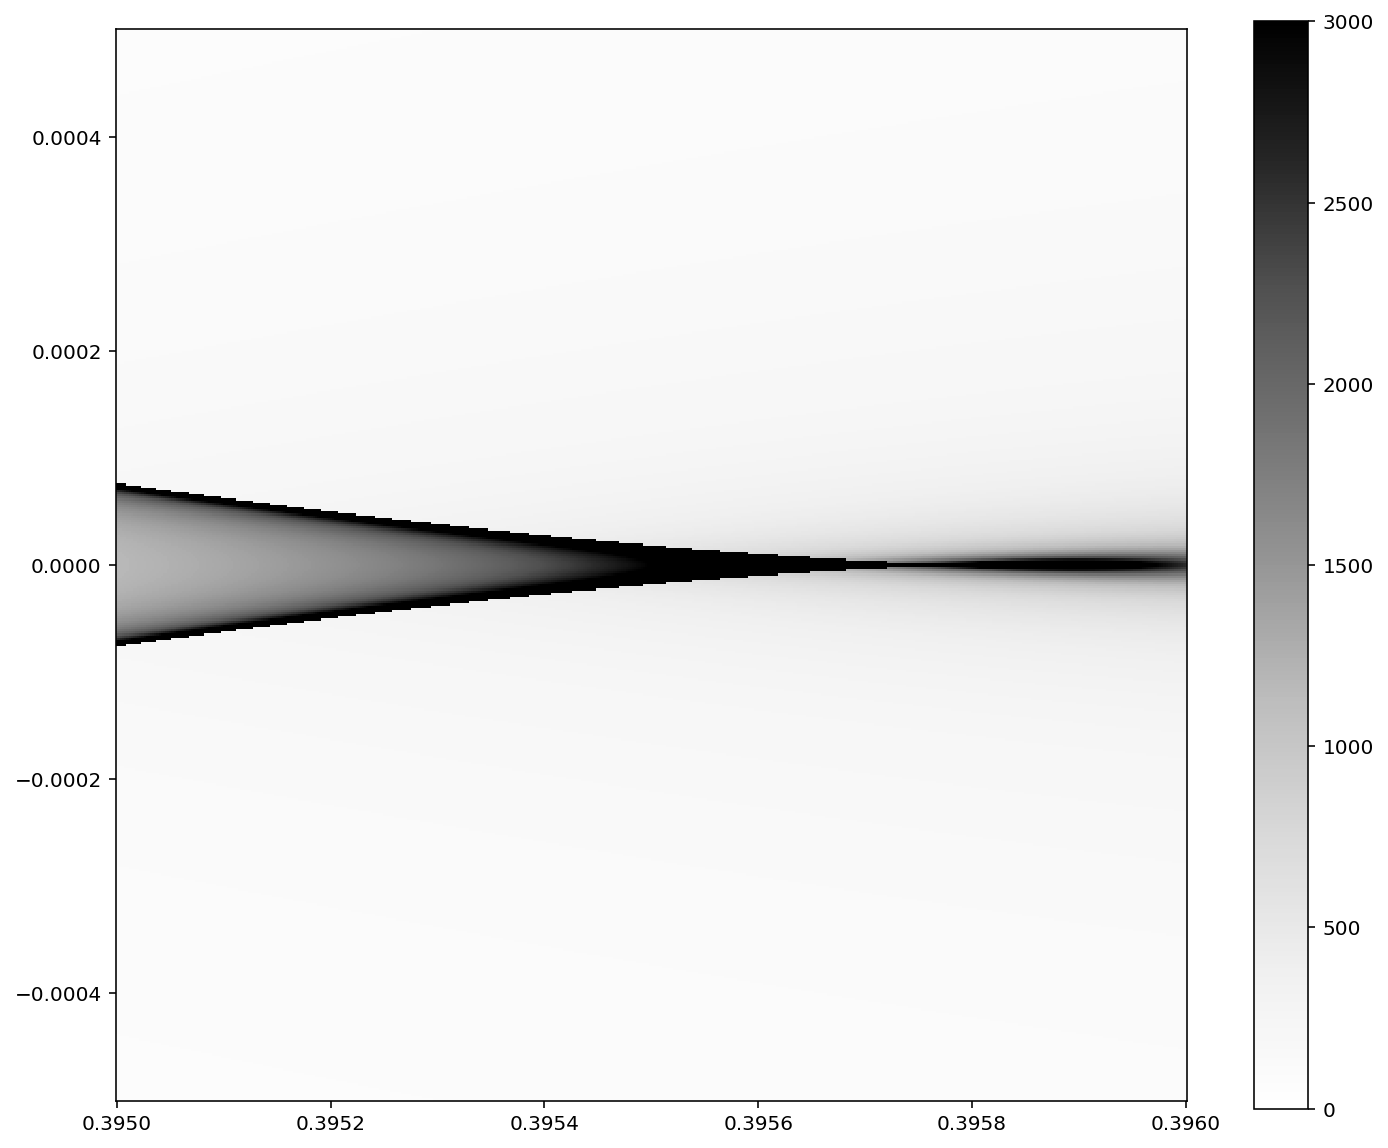

In [6]:
npts = 500
x_cent = 0.3955
y_cent = 0.
width = 0.001

x = jnp.linspace(-0.5*width + x_cent, 0.5*width + x_cent, npts)
y = jnp.linspace(-0.5*width, 0.5*width, npts)
xgrid, ygrid = jnp.meshgrid(x,y)
wgrid = xgrid + 1j*ygrid

mag = compute_magnification_map(wgrid, a, e1)

fig, ax = plt.subplots(figsize=(12,10))
im = ax.pcolormesh(
    jnp.real(wgrid), jnp.imag(wgrid), mag, cmap='Greys', norm=colors.Normalize(vmin=0, vmax=3000)
)

ax.set_aspect(1)
plt.colorbar(im)

In [7]:
# Calculate the cirtical curves and the caustic curves
solutions = VBBL.PlotCrit(2*a, q) 

# generator function iterating over _sols, _curve, or _point objects 
# making use of the next keyword
def iterate_from(item):
    while item is not None:
        yield item
        item = item.next

curves = []
for curve in iterate_from(solutions.first):
    for point in iterate_from(curve.first):
        curves.append((point.x1, point.x2))
        
critical_curves = np.array(curves[:int(len(curves)/2)])
caustic_curves = np.array(curves[int(len(curves)/2):])

In [8]:
from scipy import integrate

def compute_mag_at_point(w_point, rho_star, npts=501):
    x = jnp.linspace(jnp.real(w_point) - rho_star, jnp.real(w_point) + rho_star, npts)
    y = jnp.linspace(jnp.imag(w_point) - rho_star, jnp.imag(w_point) + rho_star, npts)
    xgrid, ygrid = jnp.meshgrid(x,y)

    # Source position
    wgrid = xgrid + 1j*ygrid
    mag = compute_magnification_map(wgrid, a, e1)
    
    source = jnp.array(Tophat2DKernel(int(jnp.floor(npts/2.))).array)
    source /= jnp.max(source)
    pix_area = jnp.diff(x)[0]**2
    
    integrate_2d = lambda x, y, f: jnp.trapz(jnp.trapz(f, x=y, axis=0), x=x, axis=0)
    
    return integrate_2d(x, y, mag*source)/integrate_2d(x, y, source)

def compute_mag_at_point_polar(w_point, rho_star):
    npts = 501
    r = jnp.linspace(0., rho_star, npts)
    theta = jnp.linspace(-jnp.pi, jnp.pi, npts)
    
    rgrid, thetagrid = jnp.meshgrid(r, theta)
    
    xgrid = rgrid*jnp.cos(thetagrid) + jnp.real(w_point)
    ygrid = rgrid*jnp.sin(thetagrid) + jnp.imag(w_point)
    wgrid = xgrid + 1j*ygrid
    
    mag = compute_magnification_map(wgrid, a, e1)
        
    integrate_2d = lambda r, theta, f: jnp.trapz(jnp.trapz(f*r, x=r, axis=0), x=theta, axis=0)
    
    return integrate_2d(r, theta, mag)/(np.pi*rho_star**2)

# @jit
# def fn(r, theta, w_point):
#     x = r*jnp.cos(theta) + jnp.real(w_point)
#     y = r*jnp.sin(theta) + jnp.imag(w_point)
#     m =  compute_magnification_map(jnp.atleast_2d(x +1j*y), a, e1)[0][0]
#     return m
    
def compute_mag_quad(w_point, rho_star):
    xc = (caustic_curves[:, 0] + x_cm) - jnp.real(w_point)
    yc = caustic_curves[:, 1] - jnp.imag(w_point)
    rc = jnp.sqrt(xc**2 + yc**2)
    thetac = jnp.arctan2(yc, xc)
    
    def fn(r, theta, w_point):
        x = r*jnp.cos(theta) + jnp.real(w_point)
        y = r*jnp.sin(theta) + jnp.imag(w_point)
        m =  compute_magnification_map(jnp.atleast_2d(x +1j*y), a, e1)[0][0]
        return m

    I = integrate.nquad(
        lambda r, theta: r*fn(r, theta, w_point), 
        ranges=[[0., rho_star,], [ -np.pi, np.pi]],
    )
    
    return I[0]/(np.pi*rho_star**2)


In [9]:
errors = []
w_points = jnp.linspace(0.39, 0.4, 30)

rho_star = 1e-03

errors = []
errors_polar = []

for w in w_points:
    mag_vbb = VBBL.BinaryMag2(2*a, q, jnp.real(w) - x_cm, jnp.imag(w), rho_star)
    mag_bf = compute_mag_at_point(w, rho_star)
    mag_bf_polar = compute_mag_at_point_polar(w, rho_star)

    errors.append(jnp.abs((mag_bf - mag_vbb)/mag_vbb))
    errors_polar.append(jnp.abs((mag_bf_polar - mag_vbb)/mag_vbb))

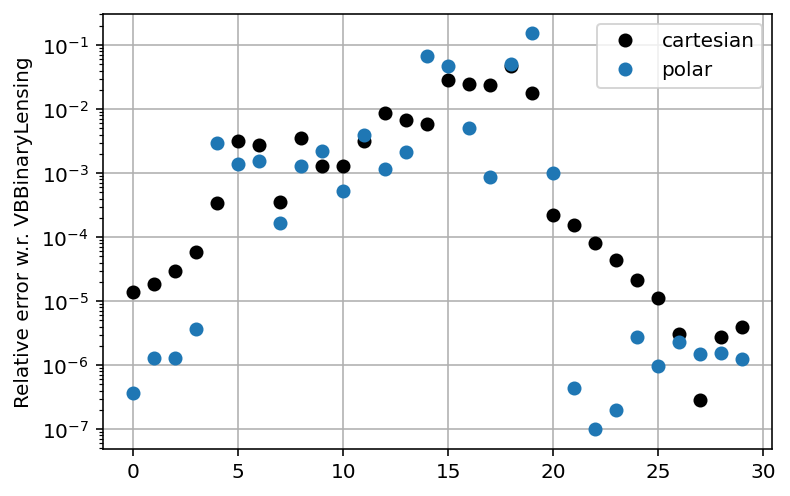

In [10]:
plt.plot(errors,  'ko', label='cartesian')
plt.plot(errors_polar, 'C0o', label='polar')
plt.legend()
plt.grid()
plt.ylabel('Relative error w.r. VBBinaryLensing')
plt.yscale('log')

# Integration in the image plane

In [3]:
# # Calculate the cirtical curves and the caustic curves
# solutions = VBBL.PlotCrit(2*a, q) 

# # generator function iterating over _sols, _curve, or _point objects 
# # making use of the next keyword
# def iterate_from(item):
#     while item is not None:
#         yield item
#         item = item.next

# curves = []
# for curve in iterate_from(solutions.first):
#     for point in iterate_from(curve.first):
#         curves.append((point.x1, point.x2))
        
# critical_curves = np.array(curves[:int(len(curves)/2)])


In [4]:
@partial(jit, static_argnames=('ncoeffs',))
def compute_image_locations(wgrid, a, e1, ncoeffs=6):
    ny, nx = wgrid.shape
    
    # Compute complex polynomial coefficients for each source position
    coeffs = vmap(vmap(lambda w: compute_polynomial_coeffs(w, a, e1)))(wgrid)
    
    # Compute roots
    roots = ehrlich_aberth(coeffs.reshape(-1, ncoeffs)).reshape(ny*nx, ncoeffs - 1)

    # Evaluate lens equation for all roots
    e = jnp.array([e1, 1 - e1])
    r = jnp.array([a, -a])
    fn = lambda z, w: lens_eq(z, w, e, r)
    lens_eq_eval = vmap(fn, in_axes=(0, 0))(roots.reshape(-1, 5), wgrid.reshape(-1))

    # Mask out roots which don't satisfy the lens equation
    mask_valid = jnp.abs(lens_eq_eval) < 1e-10
    
    images = (roots*mask_valid).reshape(wgrid.shape[0], wgrid.shape[1], ncoeffs - 1)
    
    return images

@partial(jit, static_argnames=('npts',))
def get_images_of_source_limb(w_center, rho_star, a, e1, npts=800):
    theta = jnp.linspace(-np.pi, np.pi, npts)
    x = rho_star*jnp.cos(theta) + jnp.real(w_center)
    y = rho_star*jnp.sin(theta) + jnp.imag(w_center)
    wgrid = x + 1j*y
    images = compute_image_locations(wgrid[:, None], a, e1)
    return images.reshape((npts, -1))

@jit
def lens_eq_w(z, e, r):
    return vmap(lambda z: z - jnp.sum(e/(jnp.conjugate(z) - jnp.conjugate(r))))(z)

@jit
def ang_dist(theta1, theta2):
    diff1 = (theta1 - theta2) % (2*jnp.pi)
    diff2 = (theta2 - theta1) % (2*jnp.pi)
    return jnp.min(jnp.array([diff1, diff2]), axis=0)

@jit
def min_zero_avoiding(x):
    x = jnp.sort(x)
    min_x = jnp.min(x)
    cond = min_x == 0.
    return jnp.where(cond, x[(x!=0).argmax(axis=0)], min_x)

@jit
def max_zero_avoiding(x):
    x = jnp.sort(x)
    max_x = jnp.max(x)
    cond = max_x == 0.
    return jnp.where(cond, -min_zero_avoiding(jnp.abs(x)), max_x)


@jit
def get_bbox(z):
    re_z = jnp.real(z)
    im_z = jnp.imag(z)
    bbox = [
        min_zero_avoiding(re_z),
        max_zero_avoiding(re_z),
        min_zero_avoiding(im_z),
        max_zero_avoiding(im_z),
    ]
    return jnp.array(bbox)

def get_bbox_alternative(z):
    mask = z != 0.
    bbox = [
        jnp.min(jnp.real(z)[mask]),
        jnp.max(jnp.real(z)[mask]),
        jnp.min(jnp.imag(z)[mask]),
        jnp.max(jnp.imag(z)[mask]),
    ]
    return jnp.array(bbox)

@partial(jit, static_argnames=('npts',))
def integrate_image_plane(bbox, w_center, npts=3000):
    xmin, xmax, ymin, ymax = bbox
    
    # Image plane
    x = jnp.linspace(xmin, xmax, npts)
    y = jnp.linspace(ymin, ymax, npts)
    xgrid, ygrid = jnp.meshgrid(x, y)
    zgrid = xgrid + 1j*ygrid
    
    # Lens plane
    w = lens_eq_w(zgrid.reshape(-1), e_lens, r_lens).reshape(zgrid.shape)
    x_w, y_w = jnp.real(w), jnp.imag(w)
    mask_inside = (
        (x_w - jnp.real(w_center))**2 + (y_w - jnp.imag(w_center))**2 <= rho_star**2
    ).astype(float)
    
    integrate_2d = lambda x, y, f: jnp.trapz(jnp.trapz(f, x=y, axis=0), x=x, axis=0)

    return integrate_2d(x, y, mask_inside)

@jit
def check_bbox_intersecting(bbox_a, bbox_b): 
    """True if bbox_a and bbox_b overlap."""
    xmin_a, xmax_a, ymin_a, ymax_a = bbox_a
    xmin_b, xmax_b, ymin_b, ymax_b = bbox_b

    dx = jnp.min(jnp.array([xmax_a, xmax_b])) - jnp.max(jnp.array([xmin_a, xmin_b]))
    dy = jnp.min(jnp.array([ymax_a, ymax_b])) - jnp.max(jnp.array([ymin_a, ymin_b]))
    
    return jnp.where((dx >= 0) * (dy >= 0), True, False)

@jit
def mark_intersecting_bboxes(bboxes):
    intersecting = []

    for i, bbox in enumerate(bboxes):
        intersecting.append(
            jnp.any(vmap(lambda b: check_bbox_intersecting(bbox, b))(jnp.delete(bboxes, i, axis=0)))
        )

    return jnp.array(intersecting)

@jit
def merge_bboxes(bboxes):    
    xmin = min_zero_avoiding(bboxes[:, 0])
    xmax = max_zero_avoiding(bboxes[:, 1])
    ymin = min_zero_avoiding(bboxes[:, 2])
    ymax = max_zero_avoiding(bboxes[:, 3])
    
    return jnp.array([xmin, xmax, ymin, ymax])
    
@partial(jit, static_argnames=('f',))
def extend_bboxes(bboxes, f=0.1):
    widths = bboxes[:, 1] - bboxes[:, 0]
    heights = bboxes[:, 3] - bboxes[:, 2]
        
    bboxes_ext = jnp.stack([
        bboxes[:, 0] - f*widths,
        bboxes[:, 1] + f*widths,
        bboxes[:, 2] - f*heights,
        bboxes[:, 3] + f*heights,
    ]).T
         
    return bboxes_ext

# @partial(jit, static_argnames=('K', 'niter',))
# def kmeans(X, centroids_init, K=5, niter=5):
#     # Standardize X
#     X = (X - jnp.mean(X, axis=0))/jnp.std(X, axis=0)    
    
#     assert centroids_init.shape[0] == K
    
#     centroids = centroids_init
    
#     closest_centroid = lambda p, centroids: jnp.sqrt(((p - centroids)**2).sum(axis=1)).argmin()

#     def step(centroids, labels):
#         # assign each point to its closest centroid
#         labels = vmap(lambda p: closest_centroid(p, centroids))(X)
        
#         # compute new centroid mean of each cluster
#         get_new_centroids = lambda k: ((labels == k).astype(float)[:, None]*X).mean(axis=0)
        
#         centroids = vmap(get_new_centroids)(jnp.arange(K))
        
#         return centroids, labels
    
#     centroids, labels_stacked = lax.scan(step, centroids, xs=jnp.arange(niter))
    
#     return centroids, labels_stacked[-1]

In [8]:
# Lens postion
a = 0.5*0.9

# Lens mass ratio
e1 = 0.8
e2 = 1. - e1
q = e1/e2
x_cm = (e1 - e2)*a

# System parameters
rho_star = 1e-03
e_lens = jnp.array([e1, 1. - e1])
r_lens = jnp.array([a, -a])
w_center = 0.3955  

# Get images of source limb and center
z_limb = get_images_of_source_limb(w_center, rho_star, a, e1, npts=800)

# Get seed locations within all images 
get_centroids_init = lambda z: z[(z != 0).prod(axis=1).argsort()[-1]]
centroids_init = get_centroids_init(z_limb)
centroids_init = jnp.stack([jnp.real(centroids_init), jnp.imag(centroids_init)]).T

# Add (0,0) as the last cluster, all points in this cluster are ignored in subsequent 
# simulations
centroids_init = jnp.vstack([centroids_init, jnp.array([0., 0.])])

X = jnp.stack([jnp.real(z_limb.reshape(-1)), jnp.imag(z_limb.reshape(-1))]).T

closest_centroid = lambda p, centroids: jnp.sqrt(((p - centroids)**2).sum(axis=1)).argmin()
labels = vmap(lambda p: closest_centroid(p, centroids_init))(X)



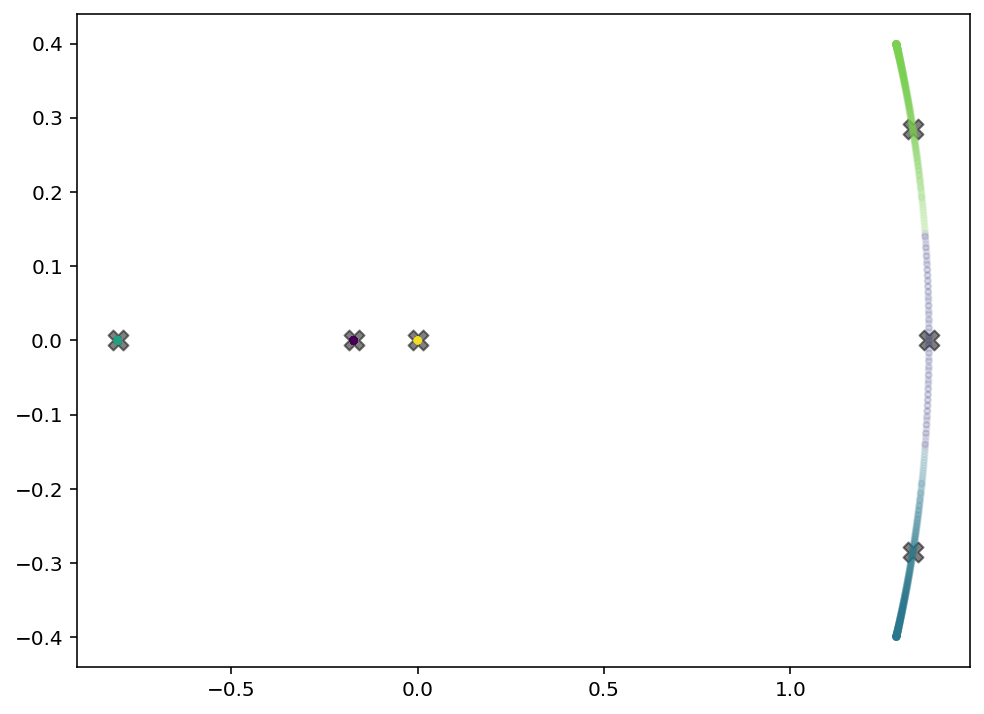

In [9]:
plt.figure(figsize=(8, 6))

plt.scatter(centroids_init[:, 0], centroids_init[:, 1], marker='X', 
    color='black', s=100, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], marker='.', alpha=0.1, c=labels)

In [10]:
# Compute bboxes
n_clusters = 5
label_idcs = jnp.arange(n_clusters)
bboxes = vmap(lambda c: get_bbox(z_limb.reshape(-1)*(labels == c).astype(float)))(label_idcs)

# Extend bboxes
bboxes = extend_bboxes(bboxes, f=0.05)

# Merge overlapping bboxes
mask_int = mark_intersecting_bboxes(bboxes)
mask_nonint = jnp.logical_not(mask_int)

bboxes_int = mask_int.astype(float)[:, None]*bboxes

bbox_merged = jnp.where(
    jnp.any(mask_int),
    merge_bboxes(bboxes_int),
    jnp.zeros(4),
)
     
# bbox_merged.block_until_ready()

Text(0.5, 1.0, 'Image plane')

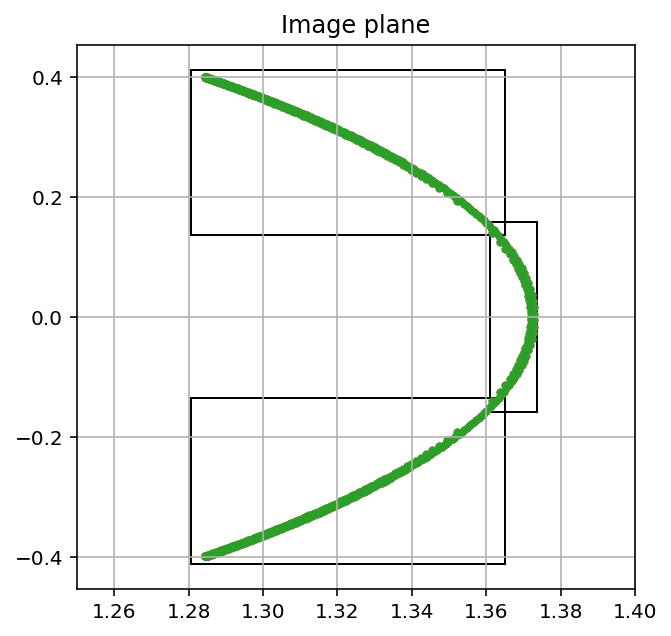

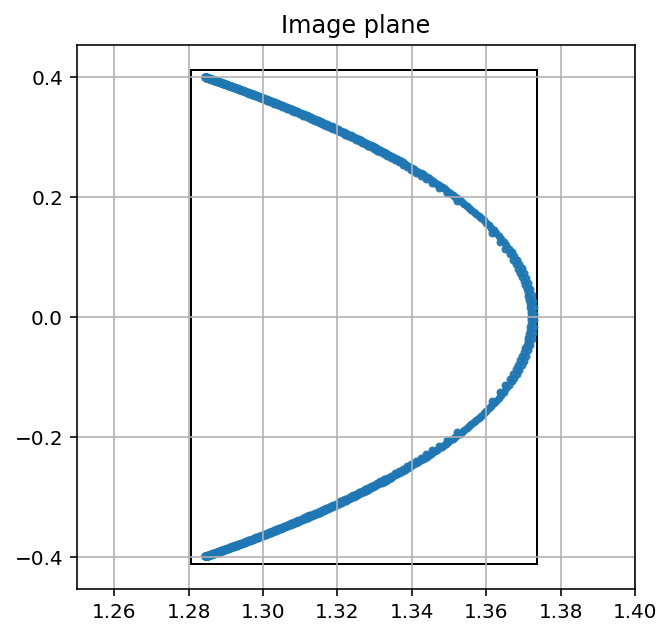

In [11]:
def plot_bbox(ax, bbox):
    xmin, xmax, ymin, ymax = bbox
    rect = patches.Rectangle((xmin, ymin), np.abs(xmax - xmin), np.abs(ymax - ymin), 
                             linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    
fig, ax = plt.subplots(figsize=(5, 5))
for i, bbox in enumerate(bboxes[mask_int]):
    plot_bbox(ax, bbox)
    ax.grid()
    ax.scatter(jnp.real(z_limb), jnp.imag(z_limb), c=f"C{i}", alpha=0.9, marker='.')
    ax.set_title("Image plane")
    # ax.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
    # ax.set(ylim=(0.17, 0.225), xlim=(1.325, 1.375))
    # ax.set_aspect(1)
    ax.set_xlim(1.25, 1.40)
    
    
fig, ax = plt.subplots(figsize=(5, 5))
plot_bbox(ax, bbox_merged)
ax.grid()
ax.scatter(jnp.real(z_limb), jnp.imag(z_limb), alpha=0.9, marker='.')
ax.set_xlim(1.25, 1.40)
ax.set_title("Image plane")

In [12]:
@partial(jit, static_argnames=('npts', 'npts_limb',))
def compute_mag_cartesian(e_lens, r_lens, w_center, rho_source, npts=3000, npts_limb=800):
    # Get images of source limb and center
    z_limb = get_images_of_source_limb(w_center, rho_source, a, e1, npts=npts_limb)

    # Get seed locations within all images 
    n_clusters = 5
    get_centroids_init = lambda z: z[(z != 0).prod(axis=1).argsort()[-1]]
    centroids_init = get_centroids_init(z_limb)
    centroids_init = jnp.stack([jnp.real(centroids_init), jnp.imag(centroids_init)]).T

    # Add (0,0) as the last cluster, all points in this cluster are ignored in subsequent 
    # simulations
    centroids_init = jnp.vstack([centroids_init, jnp.array([0., 0.])])

    X = jnp.stack([jnp.real(z_limb.reshape(-1)), jnp.imag(z_limb.reshape(-1))]).T

    closest_centroid = lambda p, centroids: jnp.sqrt(((p - centroids)**2).sum(axis=1)).argmin()
    labels = vmap(lambda p: closest_centroid(p, centroids_init))(X)

    # Compute bboxes
    label_idcs = jnp.arange(n_clusters)
    bboxes = vmap(lambda c: get_bbox(z_limb.reshape(-1)*(labels == c).astype(float)))(label_idcs)

    # Extend bboxes
    bboxes = extend_bboxes(bboxes, f=0.15)

    # Merge overlapping bboxes
    mask_int = mark_intersecting_bboxes(bboxes)
    mask_nonint = jnp.logical_not(mask_int)

    bboxes_int = mask_int.astype(float)[:, None]*bboxes
    bboxes_nonint = mask_nonint.astype(float)[:, None]*bboxes

    bbox_merged = jnp.where(
        jnp.any(mask_int),
        merge_bboxes(bboxes_int),
        jnp.zeros(4),
    )
    
    bboxes_final = jnp.vstack([bboxes_nonint, bbox_merged])
    
    # Compute integrals
    integrals = []
    for bbox in bboxes_final:
        I = jnp.where(
            jnp.all(bbox == 0),
            0.,
            integrate_image_plane(bbox, w_center, npts=npts)
        )
        integrals.append(I)
        
    I = jnp.sum(jnp.array(integrals))
        
#     def compute_integral(carry, bbox):
#         I = jnp.where(
#             jnp.all(bbox == 0),
#             0.,
#             integrate_image_plane(bbox, w_center, npts=npts)
#         )
#         return carry + I, bbox

#     I, _ = lax.scan(compute_integral, 0., xs=bboxes_final)
        
    mag = I/(np.pi*rho_source**2)
    
    return mag

In [13]:
mag = compute_mag_cartesian(e_lens, r_lens, w_center, rho_star, npts=3000, npts_limb=200)
mag.block_until_ready()

DeviceArray(241.67797111, dtype=float64)

In [14]:
%%timeit
mag = compute_mag_cartesian(e_lens, r_lens, w_center, rho_star, npts=3000, npts_limb=200)
mag.block_until_ready()

58.5 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Text(0.5, 1.0, 'Relative error')

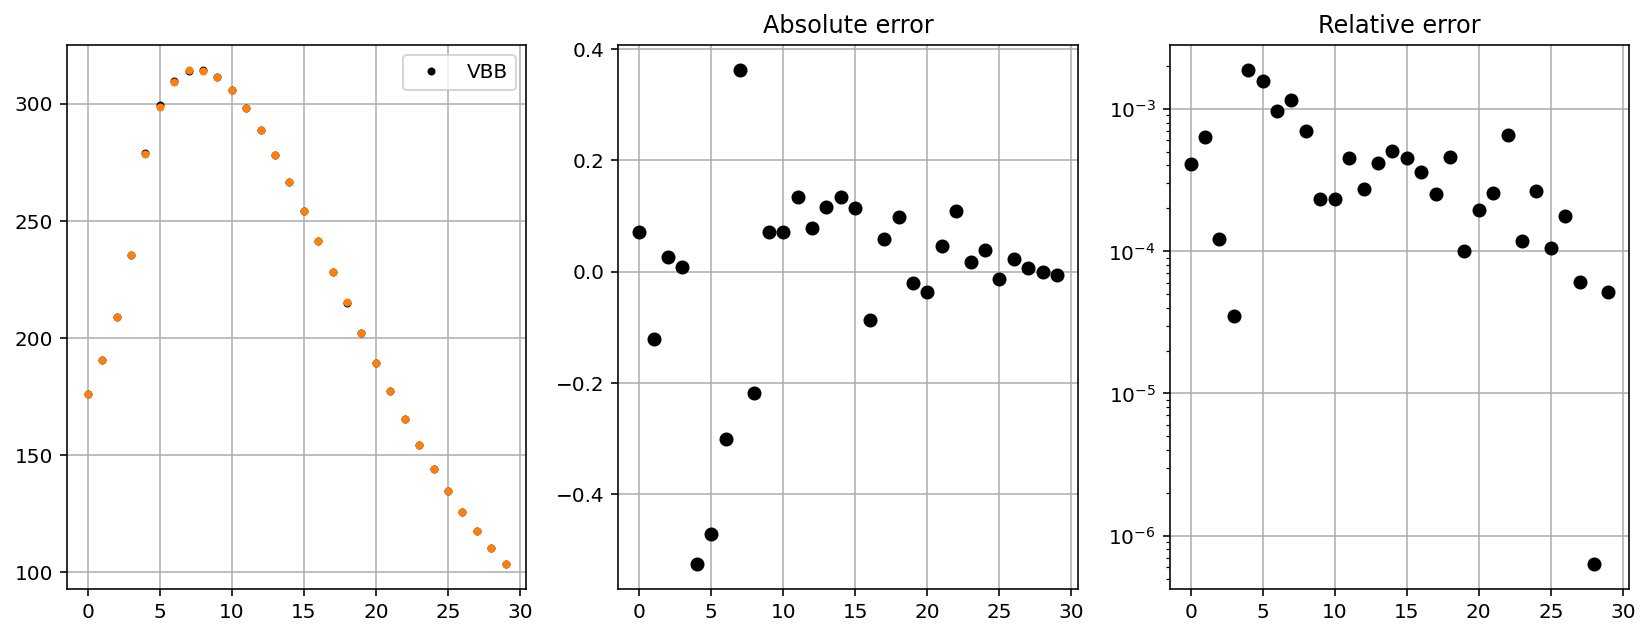

In [22]:
w_points = jnp.linspace(0.39, 0.4, 30)

rho_star = 1e-03

mags = []
mags_vbb = []

for w in w_points:
    mag_vbb = VBBL.BinaryMag2(2*a, q, jnp.real(w) - x_cm, jnp.imag(w), rho_star)
    mag = compute_mag_cartesian(e_lens, r_lens, w, rho_star, npts=3000, npts_limb=200)

    mags.append(mag)
    mags_vbb.append(mag_vbb)
    
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

ax[0].plot(np.array(mags_vbb), 'k.', label='VBB')
ax[0].plot(np.array(mags), 'C1.')
ax[1].plot(np.array(mags) - np.array(mags_vbb),  'ko')
ax[2].plot(jnp.abs((np.array(mags) - np.array(mags_vbb))/np.array(mags_vbb)),  'ko')
ax[2].set_yscale('log')
ax[0].legend()

for _a in ax:
    _a.grid()

ax[1].set_title("Absolute error")
ax[2].set_title("Relative error")

# Integration in image plane - polar coordinates

left:  -0.30147854618904313
right:  0.008324129314080587


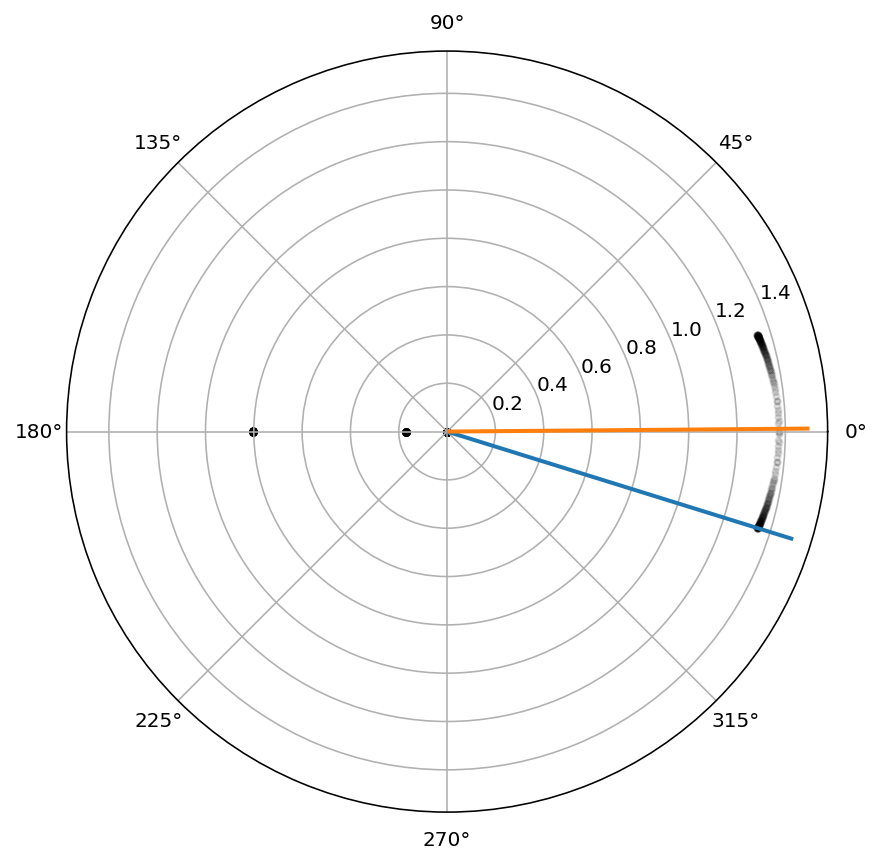

In [135]:
fig = plt.figure(figsize=(7, 7))  # Size
ax = plt.subplot(111, polar=True)  # Create subplot
ax.set_theta_zero_location('E')  

idx = 1

left = theta_limb[left_edges[idx]]
right = theta_limb[right_edges[idx]]

print("left: ", left)
print("right: ", right)

ax.vlines(left, 0, 1.5,colors='C0', lw=2)
ax.vlines(right, 0, 1.5, colors='C1', lw=2)
ax.scatter(theta_limb, r_limb, alpha=0.1, marker='.', color='black')


In [28]:

# def recursive_flood_fill(grid, row, col): 
#     # Half if out of bounds

#     # Check if out of bounds
#     if (row < 0 or row > len(grid) - 1):
#         return
#     if (col < 0 or col > len(grid[0]) - 1):
#         return
    
#     # Continue if active
#     I = fn_indicator(jnp.array([rgrid[row, col], thetagrid[row, col]]))
    
#     # Inside is true if node is unfilled and inside image
#     inside = (grid[row, col] == 0) and I
    
#     if not inside: # unfilled and inside image
#         return
            
#     # Iterate over neighbouring cells and check if they're active  
#     grid = grid.at[row, col].set(1.)
#     # print(grid[row, col])
#     # grid[row, col] = 1
#     c = [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
         
#     recursive_flood_fill(grid, c[0][0], c[0][1])
#     recursive_flood_fill(grid, c[1][0], c[1][1])
#     recursive_flood_fill(grid, c[2][0], c[2][1])
#     recursive_flood_fill(grid, c[3][0], c[3][1])
    
#     return grid


# def iterative_flood_fill(idx_i, idx_j): 
#     grid = jnp.zeros_like(rgrid)

#     inside = lambda i, j: (grid[i, j] == 0) and fn_indicator(
#         jnp.array([rgrid[i, j], thetagrid[i, j]])
#     )
    
#     m, n = len(grid), len(grid[0])
#     stack = [(idx_i, idx_j)]
         
#     while len(stack) > 0:
#         i, j = stack.pop()
        
#         grid = grid.at[i, j].set(1)
        
#         # Iterate over neighbours
#         for i, j in [(i + 1, j), (i, j + 1), (i - 1, j), (i, j - 1)]:
#             if 0 <= i < m and 0 <= j < n and inside(i, j):
#                 stack.append((i, j))

#     return grid

    
